In [1]:
import os
import tensorflow as tf
from tensorflow import keras

In [2]:
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [3]:
local_weights_file = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [4]:
pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None)

In [5]:
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [7]:
last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape : ", last_layer.output.shape)
last_output = last_layer.output

last layer output shape :  (None, 7, 7, 768)


In [8]:
from keras import layers
from keras import Model

In [9]:
# Flatten the output layer to 1 dimensoin
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024,activation="relu")(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1,activation="sigmoid")(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [10]:
import os
import pandas as pd

In [11]:
filenames = os.listdir("../cats_and_dogs_filtered/train/")
categories = []

for filename in filenames:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

In [12]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [13]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


In [14]:
df.shape

(25000, 2)

In [15]:
%matplotlib inline

import cv2
import random
import matplotlib.pyplot as plt

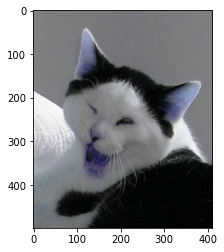

In [16]:
sample_img = random.choice(filenames)
img = cv2.imread("../cats_and_dogs_filtered/train/" + sample_img)
plt.imshow(img)

In [17]:
df["category"] = df["category"].replace({1:"dog",0:"cat"})

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_df,validation_df = train_test_split(df,test_size=0.20,random_state=42)

In [20]:
print(train_df.shape)
print(validation_df.shape)

(20000, 2)
(5000, 2)


In [21]:
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [22]:
train_df.head(2)

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog


In [23]:
validation_df.head(2)

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog


In [24]:
total_train = train_df.shape[0]
total_validation = validation_df.shape[0]
batch_size = 20

In [25]:
from keras.preprocessing.image import ImageDataGenerator

In [26]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [27]:
TRAIN_DIR = "../cats_and_dogs_filtered/train/"
VALIDATION_DIR = "../cats_and_dogs_filtered/train/"

In [28]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_DIR,
                                                    x_col="filename",
                                                    y_col="category",
                                                    batch_size=batch_size,
                                                    class_mode="binary",
                                                   target_size=(150,150))

validation_generator = test_datagen.flow_from_dataframe(validation_df,
                                                        VALIDATION_DIR,
                                                        x_col="filename",
                                                        y_col="category",
                                                       batch_size=batch_size,
                                                       class_mode="binary",
                                                       target_size=(150,150))

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                   steps_per_epoch=100,
                   epochs=20,
                   validation_steps=50,
                   verbose=2)